# Dataset

Para a nossa análise utilizaremos o conjunto de dados do Titanic, mundialmente conhecido e muito utilizado para projetos de machine learning, como um "Hello world" do mundo da ciêncida de dados.

Link para [download](https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59e4fe3d_titanic-data-6/titanic-data-6.csv)

# Perguntas

* Qual era o perfil geral dos passageiros?
* Como variou o preço da passagem em relação ao local de embarque?
* Quais fatores mais influenciaram a taxa de sobrevivência dos passageiros?
* O número de familiares a bordo do titanic influenciou na taxa de sobrevivência?
* O número de pais/filhos a bordo do titanic influenciou na taxa de sobrevivência? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_csv('titanic-data-6.csv', index_col='PassengerId')

In [10]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Limpeza de dados

Vamos padronizar os nomes das colunas para minúsculo

In [20]:
df.rename(columns= lambda x: x.lower(), inplace=True)

Podemos perceber que a idade está sendo tratada como float, vamos ver porque:

In [21]:
df.age.unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

Alguns registros possuem valores abaixo de 1, ou seja, provavelmente são bebês com menos de 1 um ano.

In [28]:
print(f'Número de passageiros com menos de 1 ano: {sum(df.age <1)}')

Número de passageiros com menos de 1 ano: 7


Podemos perceber também que existe uma certa quantidade de idades faltantes:

In [31]:
sum(df.age.isnull())

177

Existem algumas colunas que serão desnecessárias para a nossa análise, como a "ticket" e a "cabin", vamos retirá-las.

In [33]:
clean_df = df.drop(columns=['ticket', 'cabin'])

A coluna "embarked" não deixa muito explícito qual o nome do local de embarque, nesse caso vamos utilizar como referência o dicionário de dados disponibilizado no site [kaggle](https://www.kaggle.com/c/titanic/data), para enriquecer nossos dados.

In [47]:
clean_df.loc[clean_df.embarked == 'S','embarked'] = 'Southampton'
clean_df.loc[clean_df.embarked == 'C','embarked'] = 'Cherbourg'
clean_df.loc[clean_df.embarked == 'Q','embarked'] = 'Queenstown'

In [50]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
survived    891 non-null int64
pclass      891 non-null int64
name        891 non-null object
sex         891 non-null object
age         714 non-null float64
sibsp       891 non-null int64
parch       891 non-null int64
fare        891 non-null float64
embarked    889 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 109.6+ KB


Apesar de existirem muitos valores faltantes na coluna "age", se estratificarmos pela classe à qual o passageiro pertence, podemos perceber que existe um desbalanceamento, os valores faltantes para a terceira classe representa 27% do total, enquanto que para a segunda classe representa apenas 5% do total, como podemos observar na tabela abaixo:

In [80]:
comparacao = pd.concat(
    [pd.Series(clean_df.loc[clean_df.age.isnull(), 'pclass'].value_counts(), name='sem_idade'),
    pd.Series(clean_df.loc[-clean_df.age.isnull(), 'pclass'].value_counts(), name='com_idade')],
    axis=1).sort_index()
comparacao.loc[:,'perc_%'] = (comparacao['sem_idade']/ (comparacao['sem_idade']+comparacao['com_idade']))* 100
comparacao

,sem_idade,com_idade,perc_%
1,30,186,13.888889
2,11,173,5.978261
3,136,355,27.698574


Desse modo, iremos substituir os valores faltantes pela média de cada classe.

In [118]:
for i in range(1, 4):
    age_mean = clean_df.query(f'pclass == {i}').age.mean()
    clean_df.loc[clean_df.pclass == i, 'age'] = \
        clean_df.loc[clean_df.pclass == i, 'age'].fillna(age_mean)

## Exploração dos dados

### Como era o perfil geral dos passageiros do Titanic?

Para responder a essa pergunta, vamos dar uma olhada na idade, sexo, classe social, tarifa de embarque e local de embarque.

Como somente a partir do dados do nosso conjunto não é possivel determinar com exatidão qual a classe social dos passageiros, que por si só já não é um conceito exato, vamos usar como parâmetro o em qual classe do navio ele estava navegando.

In [507]:
clean_df

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked,familiares
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,7.2500,Southampton,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00000,1,0,71.2833,Cherbourg,1
3,1,3,"Heikkinen, Miss. Laina",female,26.00000,0,0,7.9250,Southampton,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1,0,53.1000,Southampton,1
5,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,8.0500,Southampton,0
6,0,3,"Moran, Mr. James",male,25.14062,0,0,8.4583,Queenstown,0
7,0,1,"McCarthy, Mr. Timothy J",male,54.00000,0,0,51.8625,Southampton,0
8,0,3,"Palsson, Master. Gosta Leonard",male,2.00000,3,1,21.0750,Southampton,4
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00000,0,2,11.1333,Southampton,2


#### Idade

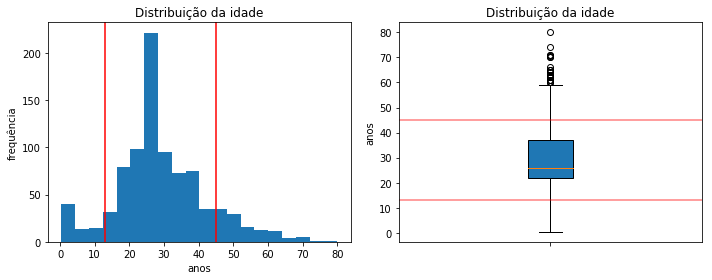

In [508]:
lim_inf = 13
lim_sup = 45

fig, (ax1, ax2)  = plt.subplots(1, 2)

ax1.hist(clean_df.age, bins=20)
ax1.set(title="Distribuição da idade", 
        xlabel ="anos", ylabel="frequência")
ax1.axvline(x=lim_inf, c='red')
ax1.axvline(x=lim_sup, c='red')

ax2.boxplot(clean_df.age, vert=True,
           patch_artist =True, meanline=True)
ax2.set(title="Distribuição da idade", 
        xlabel ="", ylabel="anos", xticklabels='')
ax2.axhline(y=lim_inf, c='red', alpha=0.5)
ax2.axhline(y=lim_sup, c='red', alpha=0.5)

fig.set_figwidth(10)
fig.tight_layout()

A partir do gráfico conseguimos percerber que a grande maioria dos passageiros tem entre 13 e 45 anos.

In [509]:
x = (clean_df.query(f"age >={lim_inf} and age <= {lim_sup}").
     shape[0]/clean_df.shape[0]) * 100
print(f'{x:.1f}% dos passageiros possuía entre {lim_inf} e {lim_sup} anos')

80.7% dos passageiros possuía entre 13 e 45 anos


#### Sexo

In [510]:
counts = clean_df.sex.value_counts()
counts.name = 'Contagem'
perc = round((counts/clean_df.sex.shape[0])*100, 1)
perc.name = 'Percentual %'
tabela = pd.concat([counts, perc], axis =1 )
tabela

,Contagem,Percentual %
male,577,64.8
female,314,35.2


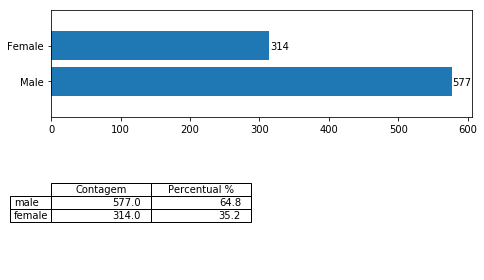

In [511]:
fig = plt.figure()
ax = plt.subplot2grid((2, 2), (0,0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1,0))
widths = clean_df.sex.value_counts()
labels = pd.Series(clean_df.sex.value_counts().index.get_values())
labels = labels.apply(lambda x: x[0].upper()+x[1:])
y= [1,2]

ax.barh(width=widths, y=y, height=0.8)
ax.set_yticks([1, 2])
ax.set_yticklabels(labels);
ax.set_ylim((0,3))
for i, width in enumerate(widths):
    ax.annotate(width, xy=(width+1, i+0.9), ha= 'left')

_.axis('off')
ax2.axis('tight')
ax2.axis('off')
ax2.table(rowLabels=tabela.index.get_values(),
         colLabels=['Contagem', 'Percentual %'],
         cellText = tabela.get_values(),
        loc= 'center')

fig.tight_layout()
fig.set_figwidth(7);

Podemos percerber que a grande maioria dos passageiros era do sexo masculino.

#### Familiares

Vamos considerar como familiares o somatório das colunas SibSp e ParCh

In [512]:
clean_df['familiares'] = clean_df[['sibsp', 'parch']].apply(sum, axis=1)

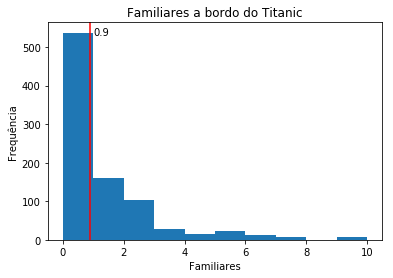

In [513]:
fam_mean = clean_df.familiares.mean()

fig, ax = plt.subplots()

ax.hist(clean_df.familiares, 10)
ax.axvline(x=fam_mean, c='red')
ax.set(title='Familiares a bordo do Titanic', 
        xlabel='Familiares',
        ylabel='Frequência')
ax.annotate(f'{fam_mean:.1f}', xy = (fam_mean+0.1, 530));

Através do histograma conseguimos ver que a grande maioria dos passageiros não viajava com familiares.

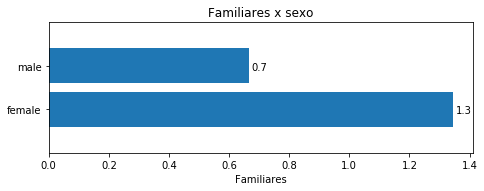

In [514]:
data = clean_df.loc[:,np.s_['familiares', 'sex']].groupby('sex').mean()
fig = plt.figure()
ax = plt.subplot2grid((2, 2), (0,0), colspan=2)
widths = data.get_values().ravel()
labels = pd.Series(data.index.get_values())
y= [1,2]

ax.barh(width=widths, y=y, height=0.8)
ax.set_yticks([1, 2])
ax.set_yticklabels(labels);
ax.set_ylim((0,3))
ax.set(title='Familiares x sexo', xlabel='Familiares')
for i, width in enumerate(widths):
    ax.annotate(f'{width:.1f}', xy=(width+ 0.01, i+0.9), ha= 'left')

fig.tight_layout()
fig.set_figwidth(7);
fig.set_figheight(5)

Outro dado interessante é que as mulheres estavam acompanhadas em média de mais familiares que os homens, o que condiz com os costumes da época.

#### Classe

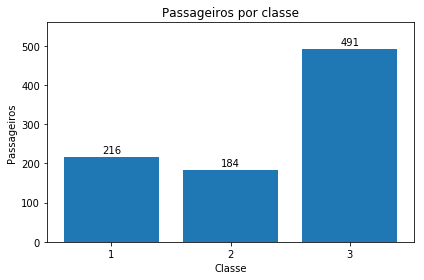

In [515]:
heights = clean_df['pclass'].value_counts().sort_index().get_values()
labels = np.arange(1,4)
fig, ax = plt.subplots()
ax.bar(x= labels, height=heights)
ax.set_xticks(labels);
ax.set(title='Passageiros por classe', xlabel='Classe',
      ylabel='Passageiros')
ax.set_ylim(0,560)
for i, v in enumerate(heights):
    ax.annotate(v, xy=(i+1, v+10), ha='center')
fig.tight_layout();

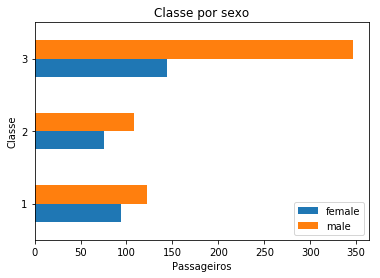

In [516]:
pd.crosstab(clean_df.loc[:,'pclass'],clean_df.loc[:,'sex']).plot(kind='barh')
plt.title('Classe por sexo')
plt.xlabel('Passageiros')
plt.ylabel('Classe')
plt.legend();

O gráfico acima mostra como os passageiros de diferentes sexos estão distribuídos pelas classes dos navios, é notável que os passageiros da terceira classe são, em sua maioria, do sexo masculino.

#### Porto de embarque

Vamos checar quantos passageiros embarcaram em cada porto.

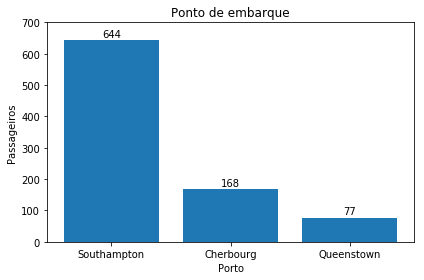

In [517]:
data=clean_df.embarked.value_counts()
labels=data.index.get_values()
fig, ax = plt.subplots()

ax.bar(x=np.arange(1,4), height=data, 
       tick_label=labels.tolist());
ax.set(title='Ponto de embarque', ylabel='Passageiros',
      xlabel='Porto');
for i, v in enumerate(data):
    ax.annotate(v, xy=(i+1, v+10), ha='center')
fig.tight_layout()
ax.set_ylim(0,700);


Comparando a tarifa média entre cada porto.

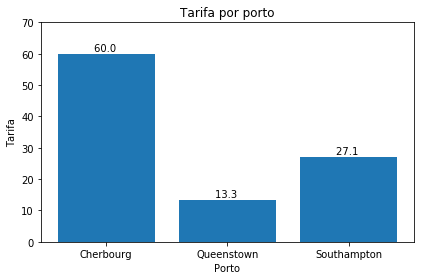

In [518]:
data = clean_df.loc[:, np.s_['fare', 'embarked']].\
        groupby('embarked').mean()
labels=data.index.get_values()
data=[i[0] for i in data.get_values().tolist()]
fig, ax = plt.subplots()

ax.bar(x=np.arange(1,4), height=data, 
       tick_label=labels.tolist());
ax.set(title='Tarifa por porto', ylabel='Tarifa',
      xlabel='Porto');
ax.set_ylim(0,70)
for i, v in enumerate(data):
    ax.annotate(f'{ v:.1f} ', xy=(i+1, v+1), ha='center')
fig.tight_layout()

### Perfil
O perfil mais comum de um passageiro do Titanic era:

* Homem
* Entre 13 e 45 anos
* Com mais 1 familiar a bordo 
* Viajando na terceira classe
* Embarcou em Southampton
* e pagou 27,1 libras pela passagem

### Quais fatores influenciaram na taxa de sobrevivência dos passageiros? 

In [532]:
pd.crosstab(clean_df.survived, clean_df.pclass, normalize='index')

pclass,1,2,3
survived,,,
0,0.145719,0.176685,0.677596
1,0.397661,0.254386,0.347953
